In [8]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""


import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.gae.optimizer import optimizerAE, optimizerVAE,get_roc_score,accuracy
from gae.gae.model import GCNModelAE, GCNModelVAE
import gae.gae.model
from gae.gae.preprocessing import preprocess_graph, sparse_to_tuple, mask_test_edges,sparse_mx_to_torch_sparse_tensor
import gae.gae.preprocessing

import pickle
import matplotlib.pyplot as plt


In [4]:
# Settings
use_cuda=False
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
epochs=200
lr=0.01 #initial learning rate
weight_decay=5e-4 #Weight for L2 loss on embedding matrix.
hidden1=32 #Number of units in hidden layer 1
hidden2=16 #Number of units in hidden layer 2
dropout=0
testEdges=0.1 #fraction of total edges for testing
valEdges=0.05 #fraction of total edges for validation
crossValidation=False
ncrossVal=6
model_str='gcn_vae' #currently available choices: gcn_vae, gcn_ae
adj_path=os.path.join('/nfs','latdata','xinyi','slideseq','xamatrices','a','f3000_knn10_connectivity.npz')
features_path=os.path.join('/nfs','latdata','xinyi','slideseq','xamatrices','x','f3000_XvarFeatures.npz')

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)

# Load data
adj=sp.load_npz(adj_path)
features=sp.load_npz(features_path)
features=sparse_mx_to_torch_sparse_tensor(features)
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj = adj+ sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)



In [5]:
if useSavedMaskedEdges:
    with open('gae/maskedEdges/seed'+str(seed)+'.pkl', 'rb') as input:
        maskedgeres = pickle.load(input)
else:
    # construct training, validation, and test sets
    maskedgeres= mask_test_edges(adj,crossValidation,ncrossVal=ncrossVal,testSize=testEdges,valSize=valEdges)
    with open('gae/maskedEdges/seed'+str(seed)+'.pkl', 'wb') as output:
        pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)


In [ ]:

train_loss=[None]*len(maskedgeres)
train_acc=[None]*len(maskedgeres)
val_loss=[None]*len(maskedgeres)
val_ap=[None]*len(maskedgeres)
val_roc=[None]*len(maskedgeres)
# loop over all train/validation sets
for seti in range(len(maskedgeres)):
    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = maskedgeres[seti]
    
    adj_norm = gae.gae.preprocessing.preprocess_graph(adj_train)
    adj_label=adj_train + sp.eye(adj_train.shape[0])
    adj_label=torch.tensor(adj_label.todense())
    
    num_nodes,num_features = features.shape

    # Create model
    if model_str == 'gcn_ae':
        model = gae.gae.model.GCNModelAE(num_features, hidden1, hidden2, dropout)
        loss_function=optimizerAE
    elif model_str == 'gcn_vae':
        model  = gae.gae.model.GCNModelVAE(num_features, hidden1, hidden2, dropout)
        loss_function=optimizerVAE
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    pos_weight = float(adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) / adj_train.sum()
    pos_weight=torch.tensor(pos_weight)
    norm = adj_train.shape[0] * adj_train.shape[0] / float((adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) * 2)

    if use_cuda:
        model.cuda()
        features = features.cuda()
        adj_norm=adj_norm.cuda()
        adj_label = adj_label.cuda()
        train_edges = train_edges.cuda()
        val_edges = val_edges.cuda()
        val_edges_false=val_edges_false.cuda()
        test_edges=test_edges.cuda()
        test_edges_false=test_edges_false.cuda()
    
    def train(epoch):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        adj_recon,mu,logvar = model(features, adj_norm)
#         print(adj_recon)
#         print(adj_label)
        loss = loss_function(adj_recon,adj_label, mu, logvar, num_nodes, pos_weight, norm)
        acc_train = accuracy(adj_recon, adj_label)
        loss.backward()
        optimizer.step()

        if not fastmode:
            # Evaluate validation set performance separately,
            # deactivates dropout during validation run.
            model.eval()
            adj_recon,mu,logvar = model(features, adj_norm)
            
        loss_val = optimizerAE(adj_recon,adj_label, mu, logvar, num_nodes, pos_weight, norm)
        roc_val,ap_val=get_roc_score(val_edges, val_edges_false,adj_recon,adj_orig)
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'roc_val: {:.4f}'.format(roc_val),
              'ap_val: {:.4f}'.format(ap_val),
              'time: {:.4f}s'.format(time.time() - t))
        return loss.item(),acc_train.item(),loss_val.item(),roc_val,ap_val
    
    print('cross-validation ',seti)
    train_loss_ep=[None]*epochs
    train_acc_ep=[None]*epochs
    val_loss_ep=[None]*epochs
    val_ap_ep=[None]*epochs
    val_roc_ep=[None]*epochs
    t_ep=time.time()
    for ep in range(epochs):
        train_loss_ep[ep],train_acc_ep[ep],val_loss_ep[ep],val_roc_ep[ep],val_ap_ep[ep]=train(ep)
    train_loss[seti]=train_loss_ep
    train_acc[seti]=train_acc_ep
    val_loss[seti]=val_loss_ep
    val_ap[seti]=val_ap_ep
    val_roc[seti]=val_roc_ep
    print('total time: {:.4f}s'.format(time.time() - t_ep))
model.eval()
adj_recon,mu,logvar = model(features, adj_norm)
roc_test,ap_test=get_roc_score(test_edges, test_edges_false,adj_recon,adj_orig)
print('test results',
      'roc_test: {:.4f}'.format(roc_test),
      'ap_test: {:.4f}'.format(ap_test))


cross-validation  0
Epoch: 0000 loss_train: 11.6791 acc_train: 0.4373 loss_val: 2.3141 roc_val: 0.4906 ap_val: 0.5455 time: 87.8830s
Epoch: 0001 loss_train: 2.5209 acc_train: 0.0862 loss_val: 1.3797 roc_val: 0.4671 ap_val: 0.5256 time: 88.1566s
Epoch: 0002 loss_train: 1.7085 acc_train: 0.1747 loss_val: 1.4901 roc_val: 0.4616 ap_val: 0.5207 time: 89.3261s
Epoch: 0003 loss_train: 1.7357 acc_train: 0.1341 loss_val: 0.9655 roc_val: 0.4947 ap_val: 0.5363 time: 90.0010s
Epoch: 0004 loss_train: 1.2160 acc_train: 0.2282 loss_val: 0.8196 roc_val: 0.5365 ap_val: 0.5650 time: 85.8652s


test results roc_test: 0.9392 ap_test: 0.9151


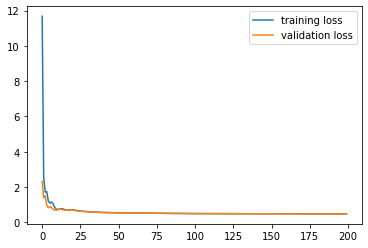

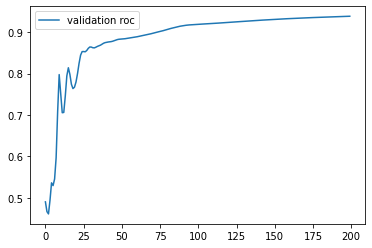

In [13]:
print('test results',
      'roc_test: {:.4f}'.format(roc_test),
      'ap_test: {:.4f}'.format(ap_test))
plt.plot(np.arange(epochs),train_loss[0])
plt.plot(np.arange(epochs),val_loss[0])
plt.legend(['training loss','validation loss'])
plt.show()
plt.plot(np.arange(epochs),val_roc[0])
plt.legend(['validation roc'])